# Modeling options and result analysis in scCODA

This tutorial notebook serves as an extension to the general tutorial and presents ways to alternate the model and perform more in-depth result analysis and diagnostics.
We will focus on:

- Modifications of the model formula and reference cell type to perform different modeling tasks
- Inference methods available in scCODA
- Advanced interpretation and analysis of results

We will again analyze the small intestinal epithelium data of mice from [Haber et al., 2017](https://www.nature.com/articles/nature24489).
First, we read in the data and perform the same preprocessing steps as in the more general tutorial:

In [1]:
# Setup
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz


Entire dataset: AnnData object with n_obs × n_vars = 10 × 8
    obs: 'Mouse', 'Condition'
Salmonella dataset: AnnData object with n_obs × n_vars = 6 × 8
    obs: 'Mouse', 'Condition'


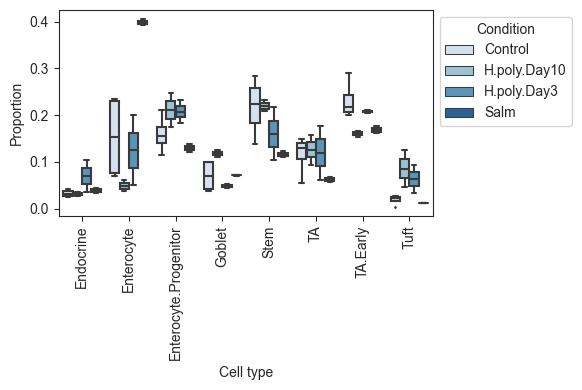

In [2]:
# Load data
cell_counts = pd.read_csv("../data/haber_counts.csv")

# Convert data to anndata object
data_all = dat.from_pandas(cell_counts, covariate_columns=["Mouse"])

# Extract condition from mouse name and add it as an extra column to the covariates
data_all.obs["Condition"] = data_all.obs["Mouse"].str.replace(r"_[0-9]", "")
print(f"Entire dataset: {data_all}")

# Select control and salmonella data
data_salm = data_all[data_all.obs["Condition"].isin(["Control", "Salm"])].copy()
print(f"Salmonella dataset: {data_salm}")

viz.boxplots(data_all, feature_name="Condition")
plt.show()


## Tweaking the model formula and reference cell type

First, we take a closer look at how changing the `formula` parameter of the scCODA model influences the results.
Internally, the formula string is converted into a linear model-like design matrix via [patsy](https://patsy.readthedocs.io/en/latest/),
which has a similar syntax to the `lm` function in the R language.

### Multi-level categories

Patsy allows us to automatically handle categorical covariates, even with multiple levels.
For example, we can model the effect of all three diseases at once:

In [3]:
# model all three diseases at once
model_all = mod.CompositionalAnalysis(data_all, formula="Condition", reference_cell_type="Endocrine")
all_results = model_all.sample_hmc()
all_results.summary()

MCMC sampling finished. (60.219 sec)
Acceptance rate: 48.0%
Compositional Analysis summary:

Data: 10 samples, 8 cell types
Reference index: 0
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.054        49.595495
Enterocyte                       1.949       121.376830
Enterocyte.Progenitor            2.352       181.616987
Goblet                           1.462        74.582061
Stem                             2.431       196.546688
TA                               1.856       110.597778
TA.Early                         2.550       221.384277
Tuft                             0.500        28.499884


Effects:
                                                 Final Parameter  \
Covariate                 Cell Type                                
Condition[T.H.poly.Day10] Endocrine                     0.000000   
                          Enterocyte              

### Different reference levels

Per default, categorical variables are encoded via full-rank treatment coding. Hereby, the value of the first sample in the dataset is used as the default (control) category.
We can select the default level by changing the model formula to `"C(<CovariateName>, Treatment('<ReferenceLevelName>'))"`:

For example, we can switch the salmonella model to test diseased versus healthy samples, which switches the sign of the only credible effect (Enterocytes).

In [4]:
# Set salmonella infection as "default" category

model_salm_switch_cond = mod.CompositionalAnalysis(data_salm, formula="C(Condition, Treatment('Salm'))", reference_cell_type="Goblet")
switch_results = model_salm_switch_cond.sample_hmc()
switch_results.summary()

MCMC sampling finished. (63.037 sec)
Acceptance rate: 49.6%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: C(Condition, Treatment('Salm'))

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.295        28.799621
Enterocyte                       3.726       327.458800
Enterocyte.Progenitor            2.581       104.205222
Goblet                           1.763        45.987161
Stem                             2.651       111.760953
TA                               2.074        62.762781
TA.Early                         2.884       141.084957
Tuft                             0.495        12.940504


Effects:
                                                                  Final Parameter  \
Covariate                                  Cell Type                                
C(Condition, Treatment('Salm'))[T.Control] Endocrine           

### Switching the reference cell type

Compositional analysis generally does not allow statements on absolute abundance changes, but only in relation to a reference category,
which is assumed to be unchanged in absolute abundance.
The reference cell type fixes this category in scCODA. Thus, an interpretation of scCODA's effects should always be formulated like:

"Using cell type xy as a reference, cell types (a, b, c) were found to credibly change in abundance"

Switching the reference cell type might thus produce different results.
For example, if we choose a cell type that heavily increases in relative abundance as the reference (such as Enterocytes in the salmonella infection data),
scCODA will likely find many credible negative effects on the other cell types.

In [5]:
model_salm_ref = mod.CompositionalAnalysis(data_salm, formula="Condition", reference_cell_type="Enterocyte")
reference_results = model_salm_ref.sample_hmc()
reference_results.summary()

MCMC sampling finished. (58.147 sec)
Acceptance rate: 56.5%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 1
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        0.868        31.594914
Enterocyte                       2.336       137.139156
Enterocyte.Progenitor            2.313       134.020952
Goblet                           1.441        56.036101
Stem                             2.560       171.570824
TA                               1.952        93.409789
TA.Early                         2.683       194.026772
Tuft                             0.260        17.201492


Effects:
                                         Final Parameter  Expected Sample  \
Covariate         Cell Type                                                 
Condition[T.Salm] Endocrine                     0.000000        57.262484   
                  Entero

## Inference algorithms in scCODA

Currently, scCODA performs parameter inference via Markov-chain Monte Carlo (MCMC) methods.
There are three different MCMC sampling methods available for scCODA:

- Hamiltonian Monte Carlo (HMC) sampling: `sample_hmc()`
- HMC sampling with Dual-averaging step size adaptation ([Nesterov, 2009](https://link.springer.com/article/10.1007/s10107-007-0149-x)): `sample_hmc_da()`
- No-U-Turn sampling ([Hoffman and Gelman, 2014](https://jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf)): `sample_nuts()`

Generally, it is recommended to use the standard HMC sampling. Other methods, such as variational inference, are in consideration.

For all MCMC sampling methods, properties such as the MCMC chain length and the number of burn-in samples are directly adjustable.

## Result analysis and diagnostics

The "getting started" tutorial explains how to do interpret the basic output of scCODA.
To follow this up, we now take a look at how MCMC diagnostics and more advanced result analysis in scCODA can be performed.

For this section, we again use the model of salmonella infection versus control group, with a reference cell type of Goblet cells.

In [6]:
model_salm = mod.CompositionalAnalysis(data_salm, formula="Condition", reference_cell_type="Goblet")
salm_results = model_salm.sample_hmc(num_results=20000)

MCMC sampling finished. (59.848 sec)
Acceptance rate: 52.1%


### Extended model summary

`result.summary_extended()` gives us, apart from the properties already explained in the basic tutorial, more information about the posterior inferred by the model.
The extended summary also includes some information on the MCMC sampling procedure (chain length, burn-in, acceptance rate, duration).

For both effects and intercepts, we also get the standard deviation (SD) and high density interval endpoints of the posterior density of the generated Markov chain.

The effects summary also includes the spike-and-slab inclusion probability for each effect, i.e. the share of MCMC samples, for which this effect was not set to 0 by the spike-and-slab prior.
A threshold on this value serves as the deciding factor whether an effect is considered statistically credible

We can also use the summary tables from `summary_extended()` as pandas DataFrames to tweak them further.
They are also accessible as `result.intercept_df` and `result.effect_df`, respectively.
Furthermore, the tables a direct result of the `summary()` function in [arviz](https://arviz-devs.github.io/arviz/index.html) and support all its functionality.
This means that we can, for example, change the credible interval:

In [7]:
salm_results.summary_extended(hdi_prob=0.9)


Compositional Analysis summary (extended):

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition
Spike-and-slab threshold: 0.579

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 59.848 sec. Acceptance rate: 52.1%

Intercepts:
                       Final Parameter  HDI 5%  HDI 95%     SD  \
Cell Type                                                        
Endocrine                        1.097   0.498    1.706  0.373   
Enterocyte                       2.336   1.853    2.836  0.302   
Enterocyte.Progenitor            2.531   2.042    3.043  0.310   
Goblet                           1.774   1.242    2.262  0.317   
Stem                             2.712   2.212    3.210  0.307   
TA                               2.120   1.606    2.681  0.329   
TA.Early                         2.879   2.399    3.390  0.301   
Tuft                             0.419  -0.252    1.014  0.398   

                       Expected Sample  
Cell Type                             


### Diagnostics and plotting

Similarly to the summary dataframes being compatible with [arviz](https://arviz-devs.github.io/arviz/index.html),
the result class itself is an extension of arviz's `Inference Data` class. This means that we can use all its MCMC diagnostic and plotting functionality.
As an example, looking at the MCMC trace plots and kernel density estimates, we see that they are indicative of a well sampled MCMC chain:

Note: Due to the spike-and-slab priors, the `beta` parameters have many values at 0, which looks like a convergence issue, but is actually not.

**Caution: Trying to plot a kernel density estimate for an effect on the reference cell type results in an error, since it is constant at 0 for the entire chain.
To avoid this, add** `coords={"cell_type": salm_results.posterior.coords["cell_type_nb"]}` **as an argument to `az.plot_trace`, which causes the plots for the reference cell type to be skipped.**

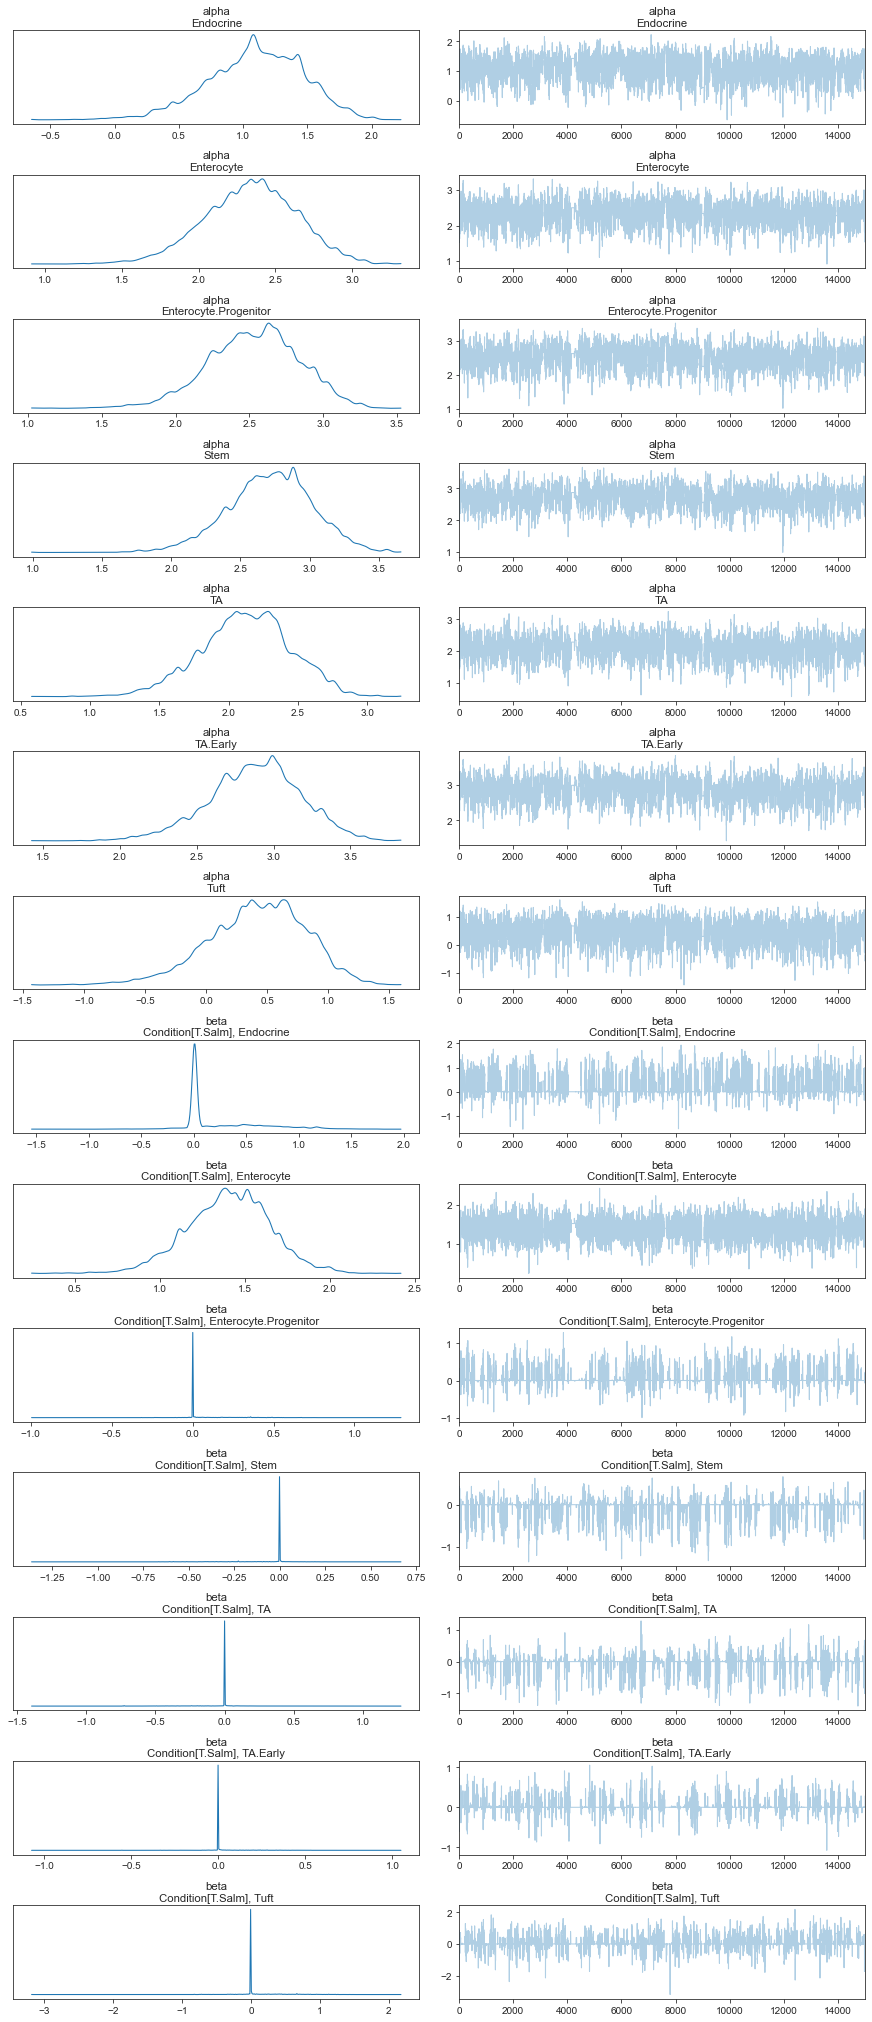

In [8]:
az.plot_trace(
    salm_results,
    divergences=False,
    var_names=["alpha", "beta"],
    coords={"cell_type": salm_results.posterior.coords["cell_type_nb"]},
)
plt.show()

### Using all cell types as reference alternatively to reference selection

scCODA uses a reference cell type that is considered to be unchanged over the experiment to guarantee the unique identifiability of results.
If no such cell type is known beforehand, setting `reference_cell_type="automatic"` will find a suited reference.
Alternatively, it is possible to find credible effects on cell types that are mostly independent of the reference.
By sequentially running scCODA and selecting each cell type as the reference once, we can then use a majority vote to find the cell types that were credibly changing more than half of the time.

Below, an example code for this procedure on the Salmonella infection data shows that only Enterocytes were found to be credible more than half of the time.
Indeed, they re credibly changing for every reference cell type except themselves.
All other cell types were found to change once at most.

In [13]:
# Run scCODA with each cell type as the reference
cell_types = data_salm.var.index
results_cycle = pd.DataFrame(index=cell_types, columns=["times_credible"]).fillna(0)

for ct in cell_types:
    print(f"Reference: {ct}")

    # Run inference
    model_temp = mod.CompositionalAnalysis(data_salm, formula="Condition", reference_cell_type=ct)
    temp_results = model_temp.sample_hmc(num_results=20000)

    # Select credible effects
    cred_eff = temp_results.credible_effects()
    cred_eff.index = cred_eff.index.droplevel(level=0)

    # add up credible effects
    results_cycle["times_credible"] += cred_eff.astype("int")

Reference: Endocrine
MCMC sampling finished. (57.191 sec)
Acceptance rate: 53.0%
Reference: Enterocyte
MCMC sampling finished. (56.156 sec)
Acceptance rate: 50.9%
Reference: Enterocyte.Progenitor
MCMC sampling finished. (60.895 sec)
Acceptance rate: 47.8%
Reference: Goblet
MCMC sampling finished. (55.759 sec)
Acceptance rate: 59.7%
Reference: Stem
MCMC sampling finished. (56.179 sec)
Acceptance rate: 52.5%
Reference: TA
MCMC sampling finished. (55.355 sec)
Acceptance rate: 53.6%
Reference: TA.Early
MCMC sampling finished. (54.951 sec)
Acceptance rate: 66.0%
Reference: Tuft
MCMC sampling finished. (56.206 sec)
Acceptance rate: 45.6%


In [15]:
# Calculate percentages
results_cycle["pct_credible"] = results_cycle["times_credible"]/len(cell_types)
results_cycle["is_credible"] = results_cycle["pct_credible"] > 0.5
print(results_cycle)


                       times_credible  pct_credible  is_credible
Endocrine                           0         0.000        False
Enterocyte                          7         0.875         True
Enterocyte.Progenitor               1         0.125        False
Goblet                              1         0.125        False
Stem                                1         0.125        False
TA                                  1         0.125        False
TA.Early                            1         0.125        False
Tuft                                1         0.125        False
